# Relational Data and Visualization
In this problem, you will be analyzing the Twitter data we extracted using [this](https://dev.twitter.com/overview/api) api. The data consists of Twitter users (with unique handles) and their attributes (e.g., number of followers), some recent tweets posted by them with attributes (e.g., time stamp, number of retweets), and the follow relationship between the users. These are available in the three (gzipped) CSV files provided to you:
- users.csv.gz - users, user attributes
- edges.csv.gz - follow edges (directed, an edge from A to B means A follows B or B is a friend of A)
- tweets.csv.gz - tweets posted by the users along with its attributes

In [2]:
import csv
import gzip
import sqlite3
import pandas as pd
import math
import matplotlib
# Use svg backend for better quality
matplotlib.use("svg")
import matplotlib.pyplot as plt
import os
if not os.environ.get("DISABLE_TESTING", False):
    %matplotlib inline
plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (10.0, 5.0) # you should adjust this to fit your screen
from testing.testing import test

## Q1. Relational Data
This question will guide you through loading Twitter data into an in-memory SQLite database and running some basic queries on it.

### Q1. Task A: Load Twitter data into SQLite database
Your first task is to use the (gzipped) csv and sqlite3 python packages to load the three csv files we give you as relations (or tables) into an SQLite in-memory database.

Loading the data from (gzipped) csv file into the database involves the following steps:
1. Identify the schema of the table (for this problem, you will only need TEXT and INTEGER attribute types)
2. Create a table with the identified schema
3. Load the contents of csv in memory
4. Insert every row of csv file as a record in the table

You can refer to [sqlite3 documentation](https://docs.python.org/2/library/sqlite3.html) and the class lecture for steps 2 and 4. For step 3, refer to the [csv documentation](https://docs.python.org/2/library/csv.html). Be sure to name your tables `users`, `edges`, and `tweets`. 

Make sure to commit (the equivalent of Ctrl+S for databases) any changes you make to the database. [This](https://www.techopedia.com/definition/16/commit) page should give you an idea about why committing is essential.

Don't decompress the `.gz` files - we do that while reading them. This is common practice when dealing with 
large amounts of text data.

Note: You should not use Pandas for this part.

In [27]:
# Helper function to get a connection to an in memory database and load Twitter data using your implemented function
def get_loaded_connection(load_twitter_data_sqlite3_test_impl, users_filepath, 
                         edges_filepath, tweets_filepath):
    conn = sqlite3.connect(":memory:")
    conn.text_factory = str
    load_twitter_data_sqlite3_test_impl(conn, users_filepath, edges_filepath, tweets_filepath)
    return conn


def load_twitter_data_sqlite3_test(load_twitter_data_sqlite3_test_impl):
    conn = get_loaded_connection(load_twitter_data_sqlite3_test_impl, 
                                 'users.csv.gz', 'edges.csv.gz', 'tweets.csv.gz')
    cursor = conn.cursor()

    # Check all tables were created
    cursor.execute("SELECT name FROM sqlite_master WHERE type = 'table';")
    test.equal(set(cursor.fetchall()), {('edges',), ('tweets',), ('users',)})

    try:
        # Check number of entries in users table
        cursor.execute('SELECT COUNT(*) FROM users;')
        test.equal(cursor.fetchone(), (12403,))
    except sqlite3.OperationalError:
        test.true(False)

    try:
        # Check user table entry
        cursor.execute("SELECT screen_name FROM users WHERE name='Donald J. Trump';")
        test.equal(cursor.fetchone(), ('realDonaldTrump',))
    except sqlite3.OperationalError:
        test.true(False)
    

@test
def load_twitter_data_sqlite3(conn, users_filepath, edges_filepath, tweets_filepath) :
    """ Load twitter data in the three files as tables into an in-memory SQLite database
    Input:
        conn (sqlite3.Connection) : Connection object corresponding to the database; used to perform SQL commands.
        users_filepath (str) : absolute/relative path to users.csv file
        edges_filepath (str) : absolute/relative path to edges.csv file
        tweets_filepath (str) : absolute/relative path to tweets.csv file
    Output:
        None
    """
    def read_n_load(file, num_columns,whichTable):
        insertArg = ",".join("?"*num_columns)
        with gzip.open(file, 'rt', encoding = 'utf-8') as f:
            files = csv.reader(f)
            for whichRow, row in enumerate(files):
                if whichRow == 0:
                    continue
                cursor.executemany("INSERT INTO {} VALUES ({});".format(whichTable,insertArg), [(row)])
        f.close()
        conn.commit()
    
    cursor = conn.cursor()
    #let us first create the user table 
    cursor.execute("""CREATE TABLE users (
                    name TEXT,
                    screen_name TEXT PRIMARY KEY, 
                    location TEXT, 
                    created_at TEXT, 
                    friends_count TEXT, 
                    followers_count TEXT, 
                    statuses_count TEXT, 
                    favourites_count TEXT);""")
    
    #let us create the friends circle
    cursor.execute("""CREATE TABLE edges (
                  screen_name TEXT,
                  friend TEXT);""")
    
    #let us create the tweets tabel 
    cursor.execute("""CREATE TABLE tweets (
                    screen_name TEXT,
                    created_at TEXT,
                    retweet_count INTEGER,
                    favorite_count INTEGER,
                    text TEXT);""")
    #we must commit to create such data set
    conn.commit()
    
    #now let us insert all the values for users
    read_n_load(users_filepath, 8,'users')
    
    #now let us inser all the values for edegs 
    read_n_load(edges_filepath, 2, 'edges')
    
    #now let us insert all the values for tweets
    read_n_load(tweets_filepath, 5, 'tweets')

### TESTING load_twitter_data_sqlite3: PASSED 3/3
###



### Q1. Task B: Trending tweets in a topic
Twitter is regarded as an invaluable source of valuable information. Hence, one of the favorite tasks of data miners is the analyse the trending tweets in a given topic.

This task requires you to retrieve the top N most trending tweets (in descending order of trending_score) about a given topic (which is a list of keywords). The following information may be useful:

- A tweet is said to be about a given topic if it contains any of the given topical phrases/keywords.
- We will use the following simple trending_score: retweet_count + favorite_count. Tweets with higher trending_score must be ranked before the ones with lower trending_score.
- Your result must contain unique tweets. If a tweet text occurs multiple times, display it only once with its highest trending_score.
- Break ties by sorting the tweets in alphabetical order.

The output schema should be as follows:

|tweet (TEXT)| trending_score (INTEGER) |
| :--- |:--- |
| | |

The default inputs to the function will retrieve 5 trending tweets about topic Hillary Clinton. 

In [43]:
def trending_tweets_test(trending_tweets_impl):
    conn = get_loaded_connection(load_twitter_data_sqlite3, 'users.csv.gz', 'edges.csv.gz', 'tweets.csv.gz')
    
    # Get top trending tweet
    results = trending_tweets_impl(conn.cursor(), N=1)
    test.equal(results.fetchone(), ("Hillary just gave a disastrous news conference on the tarmac to make up for poor performance last night. She's being decimated by the media!", 37903))


@test
def trending_tweets(cursor, topical_phrases=['Hillary', 'Clinton'], N=5):
    """ Retrieves the top N trending tweets containing one or more of the given topical phrases.
    Input:
        cursor (sqlite3.Cursor): Cursor object to query the database.
        topical_phrases (list of strings): A list of keywords identifying a topic.
        N: Number of trending tweets to retrieve
    Output:
        results (sqlite3.Cursor): Cursor object which can be used to iterate over the retrieved records/tuples.
    """
    keyWordArgs = []
    for keyWord in topical_phrases:
        keyWordArgs.append('Text LIKE "%{}%"'.format(keyWord))
    keyWordArgs = " OR ".join(keyWordArgs)
    
    args = '''SELECT DISTINCT text, (retweet_count+favorite_count) AS trending_count FROM tweets WHERE {} ORDER BY trending_count DESC, text ASC LIMIT {};'''.format(keyWordArgs, str(N))
    print(args)
    query = args
    results = cursor.execute(query)
    return results

SELECT DISTINCT text, (retweet_count+favorite_count) AS trending_count FROM tweets WHERE Text LIKE "%Hillary%" OR Text LIKE "%Clinton%" ORDER BY trending_count DESC, text ASC LIMIT 1;
### TESTING trending_tweets: PASSED 1/1
###



### Q1. Task C: Tweet recommendation
How does Twitter go about populating the feed for a user? While Twitter may use a comple models to do this, in this task, we will use a Simple Tweet Recommender (STR), which recommends a user's tweets to all users who follow him/her (without checking for possible duplicates; i.e., STR may recommend the same tweet twice if two of a user's friends have posted it).

In this task, you will write a query to determine the number of tweets recommended to each user. The order of results does not matter.

Hints:

 1. The simplest way to achieve this is to use some type of `JOIN` over all three tables.
 2. Report the results on all users present in the users table. The number of records in your output should match that in the "users" table.
 3. Not all users have friends; you must correctly handle this

The output schema should be:

|screen_name (TEXT)| num_tweets (INTEGER) |
| :--- |:--- |
| | | |


In [46]:
def num_tweets_in_feed_test(num_tweets_in_feed_impl):
    conn = get_loaded_connection(load_twitter_data_sqlite3, 'users.csv.gz', 'edges.csv.gz', 'tweets.csv.gz')
    results = num_tweets_in_feed_impl(conn.cursor()).fetchall()

    test.equal(len(results), 12403)
    test.equal(list(filter(lambda x: x[0] == 'TrumpGolf', results)), [('TrumpGolf', 1925)])


@test
def num_tweets_in_feed(cursor):
    """ Retrieves the number of tweets STR recommends to each Twitter user.
    Input:
        cursor (sqlite3.Cursor): Cursor object to query the database.
    Output:
        results (sqlite3.Cursor): Cursor object which can be used to iterate over the retrieved records/tuples.
    """
    query =  "SELECT users.screen_name, COUNT(text) AS num_tweets FROM users " +\
             "LEFT JOIN edges ON edges.screen_name = users.screen_name " +\
             "LEFT JOIN tweets ON tweets.screen_name = edges.friend GROUP BY users.screen_name;"

    return cursor.execute(query)

### TESTING num_tweets_in_feed: PASSED 2/2
###



## Q2. Visualization
In this question, you will load all data into pandas dataframes and analyse (and visualize!) some interesting trends using [matplotlib](http://matplotlib.org) python package.

### Q2. Task A: Load Twitter data using pandas 
Fill in the following method stub and return the data frames for users, edges and tweets.

Pandas will treat missing values as NaNs by default. However, for this assignment, you should treat missing values (i.e., empty strings in the csv files) as empty strings.

In [47]:
def load_twitter_data_pandas_test(load_twitter_data_pandas_impl):
    (users_df, edges_df, tweets_df) = load_twitter_data_pandas_impl(
        'users.csv.gz', 'edges.csv.gz', 'tweets.csv.gz')

    try:
        test.equal(users_df.at[0, 'name'], 'Donald J. Trump')
    except AttributeError:
        test.true(False)

    try:
        test.equal(users_df.at[4, 'location'], 'DC')
    except AttributeError:
        test.true(False)


@test
def load_twitter_data_pandas(users_filepath, edges_filepath, tweets_filepath):
    """ Loads the Twitter data from the csv files into Pandas dataframes
    Input:
        users_filepath (str) : absolute/relative path to users.csv file
        edges_filepath (str) : absolute/relative path to edges.csv file
        tweets_filepath (str) : absolute/relative path to tweets.csv file
    Output:
        (pd.DataFrame, pd.DataFrame, pd.DataFrame) : A tuple of three dataframes, the first one for users,
                                                    the second for edges and the third for tweets.
    """
    users_df = pd.read_csv(users_filepath, sep=',' , compression = 'gzip')
    edges_df = pd.read_csv(edges_filepath, sep=',' ,compression = 'gzip')
    tweets_df = pd.read_csv(tweets_filepath, sep=',' , compression = 'gzip')
    return (users_df, edges_df, tweets_df)

### TESTING load_twitter_data_pandas: PASSED 2/2
###



### Q2. Task B: Correlation
Statisticians and data analysts usually like to study about correlation between different observed variables. This helps uncover interesting patterns in the data such as causal relationships (e.g., snow on the road leads to increase in number of accidents). Correlation studies are important for multiple reasons:
- While [correlation does not imply causation](https://en.wikipedia.org/wiki/Correlation_does_not_imply_causation), a lack of correlation implies a lack of causation. This can be used to rule out many causal relationships.
- Correlation helps with prediction. The more closely related two variables are, the easier it is to predict one from the other.

In this task, we ask you to plot the friends_count (on y-axis) vs the followers_count (on x-axis) using the matplotlib package. [Here](http://matplotlib.org/examples/shapes_and_collections/scatter_demo.html) is an example to get started with scatter plots.

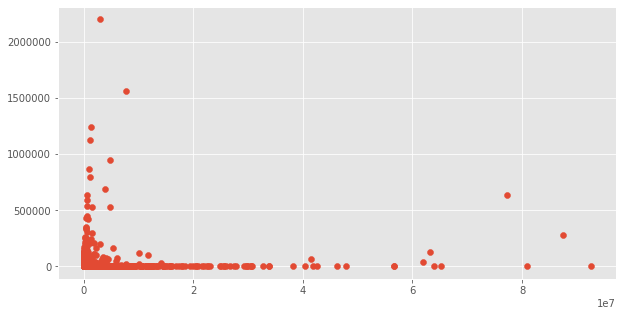

### TESTING plot_friends_vs_followers: PASSED 0/0
###



In [49]:
def plot_friends_vs_followers_test(plot_friends_vs_followers_impl):
    (users_df, edges_df, tweets_df) = load_twitter_data_pandas('users.csv.gz', 'edges.csv.gz', 'tweets.csv.gz')
    p = plot_friends_vs_followers_impl(users_df)
    plt.show()


@test
def plot_friends_vs_followers(users_df):
    """ Plots the friends_count (on y-axis) against the followers_count (on x-axis).
    Input:
        users_df (pd.DataFrame) : Dataframe containing Twitter user attributes,
                                    as returned by load_twitter_data_pandas()
    Output:
        (matplotlib.collections.PathCollection) : The object returned by the scatter plot function
    """
    return plt.scatter(list(users_df['followers_count']),list(users_df['friends_count']))

Do you see a correlation between these two variables from your scatter plot? Let's measure this quantitatively using the [Pearson's correlation coefficient](https://en.wikipedia.org/wiki/Pearson_product-moment_correlation_coefficient). 

For a set of observations $(X,Y) = [(x_1,y_1), (x_2,y_2), ... , (x_n,y_n)]$, the Pearson's correlation coefficient is a measure of the linear dependence between two variables $X$ and $Y$, giving a value between +1 and −1 inclusive, where 1 is total positive correlation, 0 is no correlation, and −1 is total negative correlation.

$r=r_{xy}={\frac {n\sum x_{i}y_{i}-\sum x_{i}\sum y_{i}}{{\sqrt {n\sum x_{i}^{2}-(\sum x_{i})^{2}}}~{\sqrt {n\sum y_{i}^{2}-(\sum y_{i})^{2}}}}}$

Now, fill in the following function to compute the Pearson's correlation coefficient between friends_count and followers_count.

In [121]:
def correlation_coefficient(users_df):
    """ Plots the friends_count (on y-axis) against the followers_count (on x-axis).
    Input:
        users_df (pd.DataFrame) : Dataframe containing Twitter user attributes,
                                    as returned by load_twitter_data_pandas()
    Output:
        (double) : correlation coefficient between friends_count and followers_count
    """

    correlation = users_df.corr(method='pearson', min_periods=1)['friends_count'][1]
    return correlation

#     import numpy as np
#     followers = np.array(users_df['followers_count'])
#     friends = np.array(users_df['friends_count'])
    
#     nXY = len(followers) * sum(followers * friends)
#     sumX = sum(followers)
#     sumY = sum(friends)
#     top = nXY - sumX * sumY
    
#     sumX2 = sum([x**2 for x in followers])
#     sumY2 = sum([y**2 for y in friends])
    
#     sqrLeft = math.sqrt(len(followers) * sumX2 - sumX**2)
#     sqrRight = math.sqrt(len(friends) * sumY2 - sumY**2)
    
#     correlation = (top) / (sqrLeft * sqrRight)
#     return correlation
#test
# users_df, _, _ = load_twitter_data_pandas("users.csv.gz", "edges.csv.gz", "tweets.csv.gz")
# correlation_coefficient(users_df)

0.09308640516482404

### Q2. Task C: Degree distribution
If you are not familiar with graph theory and/or graph mining, skip the first paragraph.

As you're familiar with graphs, you might know that the degree of a node is the number of connections it has to other nodes. A common statistic to look out for in the case of real world graphs is the degree distribution. Literature says degrees of nodes in real world graphs follow a [power law distribution](https://en.wikipedia.org/wiki/Power_law). The implication is that a scatter plot of num_users versus k (as we will define below) yields an almost straight line. In this task, we shall verify whether the given crawl of Twitter network satisfies this property.

Let us call the number of friends a Twitter user has as his/her degree. The degree distribution is a histogram of the number of friends. Your task is to visualize this histogram. Use the default number of bins.

Do you notice any surprising/unexpected pattern? What can you say about the way in which the Twitter data was collected?

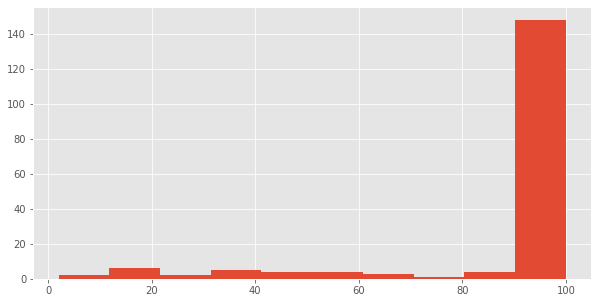

### TESTING degree_distribution: PASSED 0/0
###



In [139]:
def degree_distribution_test(degree_distribution_impl):
    (users_df, edges_df, tweets_df) = load_twitter_data_pandas('users.csv.gz', 'edges.csv.gz', 'tweets.csv.gz')
    h = degree_distribution_impl(edges_df)
    plt.show()
    

@test
def degree_distribution(edges_df):
    """ Plots the distribution of .
    Input:
        edges_df (pd.DataFrame) : Dataframe containing Twitter edges,
                        as returned by load_twitter_data_pandas()
    Output:
        (array, array, list of Patch objects) : Tuple of the values of the histogram bins, 
                        the edges of the bins and the silent list of individual patches used to create the histogram.
    """
    allGroups=edges_df.groupby('screen_name').groups
    allIndex = allGroups.keys()
    allCounts = [len(allGroups[key]) for key in allIndex]
    return plt.hist(allCounts)